### Read all spectra into same format
1. Get all saved spectra and try to force them into same namespace with uniform metadata
2. Check if there are the same spectra (or subparts in the spectra and note these)
3. Try to remove the same spectra
4. Save all spectra to uniform name space

In [60]:
import numpy as np
import pandas as pd
from pandas.errors import ParserWarning
import re
from pathlib import Path
import warnings

In [3]:
# local setup
WDIR = Path().cwd().parent

In [4]:
# load data of all planets with transmission or emission data from exoplanet archive
EMISSION_DATABASE_PATH = WDIR / "data/emissionspec.csv"
TRANSMISSION_DATABASE_PATH = WDIR / "data/transitspec.csv"

df_emission = pd.read_csv(EMISSION_DATABASE_PATH, header=18, index_col=0)
df_transmission = pd.read_csv(TRANSMISSION_DATABASE_PATH, header=26, index_col=0)


In [5]:
# read all spectra
# BE spectra
SPECTRA_BE_PATH = WDIR / "data/SpectraBE"
# Transmission spectra
TRANSMISSION_SPECTRA_PATH = WDIR / "data/transmission"
# Emission spectra
EMISSION_SPECTRA_PATH = WDIR / "data/emission"


In [111]:
exts = [".txt", ".csv"]
def get_all_spectra_files_in_path(path, ):
    paths = list([
        p for p in Path(path).glob('*') if (p.suffix in exts and p.is_file())
    ])
    return paths

In [121]:
re_author = ""

class Spectrum:
    """
    Class to read and write uniform spectrum files from diverse input data.
    """

    cases = {
        "SpectraBE": {
            "type": ".txt",
            "case": "SpectraBE",
            # "data_reader": None,
            "pd_kws": {
                "header": None,
                "index_col": False,
                "delimiter": "\\s+",
                "engine": "python",
                "comment": "#",
                "names": ["Wavelength (microns)", "Delta Wavelength (microns)", "(Rp/Rs)^2", "(Rp/Rs)^2 +/-uncertainty"],
            }
        },
        "transmission": {
            "case": "transmission",
        },
        "transmission.txt": {
            "type": ".txt",
            "case": "transmission.txt",
            # "data_reader": None,
            "pd_kws": {
                "skiprows": 15,
                "header": None,
                "index_col": False,
                "delimiter": "\\s+",
                "engine": "python",
                "comment": "#",
                "names": ["Wavelength (microns)", "Delta Wavelength (microns)", "(Rp/Rs)^2", "(Rp/Rs)^2 +/-uncertainty"],
            }
        },
        "transmission.csv": {
            "type": ".csv",
            "case": "transmission.csv",
            # "data_reader": None,
            "pd_kws": {
                # "skiprows": 15,
                "header": 0,
                "index_col": False,
                # "delimiter": ",",
                "engine": "python",
                "names": ["Wavelength (microns)", "Delta Wavelength (microns)", "(Rp/Rs)^2", "(Rp/Rs)^2 +/-uncertainty"],
            }
        },
    }

    def __init__(self, path: Path):
        if isinstance(path, str):
            path = Path(path)
        self.path = path
        self.name = path.name
        self.origin = path.parent.name
        self.in_dtype = path.suffix

        self.case = None
        self.data_reader = None
        self.in_data = None

        self.out_filename = None
        self.out_data = None

        self.infer_case()
        warnings.filterwarnings("error")
        try:
            self.data_reader()
        except ParserWarning:
            warnings.resetwarnings()
            self.case["pd_kws"] = self.__class__.cases["SpectraBE"]["pd_kws"]
            self.case["pd_kws"]["delimiter"] =  "\\s+" # "    " # None # "    "
            self.case["pd_kws"]["engine"] =  "python"
            self.case["pd_kws"]["comment"] =  "#"
            if self.name == "WASP-121b_Transmission_STIS_WFC3_Evans2018_AJ.txt":
                self.case["pd_kws"]["names"] = ['Wavelength (microns)',
                                                'Channel 1/2-width(microns)',
                                                'Rpl/Rstar',
                                                'Rpl/Rstar -1sigma error',
                                                'Rpl/Rstar+1sigma error']
            self.data_reader()
        warnings.resetwarnings()

    def __repr__(self):
        s = f"Spectrum object: " \
            f"Name: {self.name} " \
            f"Type: {self.in_dtype} " \
            f"Origin: {self.origin} " \
            f"at {self.path}"
        return s

    def infer_case(self):
        self.case = self.__class__.cases[self.origin]
        if self.case["case"] == "transmission":
            self.case = self.__class__.cases[self.origin + self.in_dtype]

        if self.case["case"] == "SpectraBE":
            self.data_reader = self.read_txt
        elif self.case["case"] == "transmission.txt":
            self.data_reader = self.read_txt
        elif self.case["case"] == "transmission.csv":
            self.data_reader = self.read_csv
        else:
            raise NotImplementedError("infer_case could not infer case")

    def read_txt(self, ):
        self.in_data = pd.read_table(self.path, **self.case["pd_kws"])
        # print(self.in_data)

    def read_csv(self, ):
        self.in_data = pd.read_csv(self.path, **self.case["pd_kws"])
        # print(self.in_data)

    def _info_from_file_name(self, uid=0):
        split_name = str(self.name).split("_")
        planet = split_name[0]
        instrument = "" # default NA
        author = "" # default NA
        year = "" # default NA

        self.out_filename = f"{planet}_{uid}.txt"


    def _write_out_data(self):
        self.out_data = self.in_data.copy(deep=True)

        if self.name == "WASP-121b_Transmission_STIS_WFC3_Evans2018_AJ.txt":
            # "Wavelength (microns)", "Delta Wavelength (microns)", "(Rp/Rs)^2", "(Rp/Rs)^2 +/-uncertainty"
            self.out_data["Delta Wavelength (microns)"] = 2 * self.out_data['Channel 1/2-width(microns)']
            self.out_data["(Rp/Rs)^2"] = self.out_data['Rpl/Rstar'] ** 2
            self.out_data["(Rp/Rs)^2 +/-uncertainty"] = self.out_data[['Rpl/Rstar -1sigma error', 'Rpl/Rstar+1sigma error']].max(axis=1)

            self.out_data = self.out_data[["Wavelength (microns)", "Delta Wavelength (microns)", "(Rp/Rs)^2", "(Rp/Rs)^2 +/-uncertainty"]]

        # TODO write out data for other cases which have mismatched entries
        # match conversions using dict mapping


    def save_data(self, dir_path=WDIR / "data/out_data", uid=0):
        self._info_from_file_name(uid=uid)
        self._write_out_data()

        file_path = dir_path / self.out_filename
        self.out_data.to_csv(file_path,
                             sep=" ", header=False, index=False,
                             float_format="%.32e") # 32 digit precision, overkill



In [123]:
files_be = get_all_spectra_files_in_path(SPECTRA_BE_PATH)
files_transmission = get_all_spectra_files_in_path(TRANSMISSION_SPECTRA_PATH)

all_files = [*files_be, *files_transmission]

all_spectra = [Spectrum(file) for file in all_files]

[spec.save_data(uid=i) for i, spec in enumerate(all_spectra)];

/tmp/ipykernel_1086046/3030999262.py:111: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  self.in_data = pd.read_table(self.path, **self.case["pd_kws"])


ParserWarning: 

In [116]:
# parser cannot properly handle # commented lines -> useless

from configparser import ConfigParser
config = ConfigParser()

config.read((WDIR / "data/transmission/HAT-P-1b_transmission_Sing2016.txt"))

print(config)

MissingSectionHeaderError: File contains no section headers.
file: PosixPath('/home/lukasw/Documents/git/compla/data/transmission/HAT-P-1b_transmission_Sing2016.txt'), line: 13
'         0.3625000    0.03750000   0.01412295   0.00010458  \n'

In [ ]:
# pattern:
# [(STIS)|(WFC3)|(WFC)]
# [GE][0-9][0-9][0-9][MLH(MB)(LB)]
# GO [0-9]{5}


    Wavelength (microns)  Channel 1/2-width(microns)  Rpl/Rstar  \
0                1.12625                    0.011557   0.000054   
1                1.14775                    0.011585   0.000052   
2                1.16860                    0.011570   0.000047   
3                1.18880                    0.011551   0.000041   
4                1.20835                    0.011534   0.000048   
5                1.22750                    0.011614   0.000050   
6                1.24645                    0.011578   0.000042   
7                1.26550                    0.011572   0.000047   
8                1.28475                    0.011574   0.000044   
9                1.30380                    0.011414   0.000048   
10               1.32260                    0.011480   0.000036   
11               1.34145                    0.011686   0.000050   
12               1.36050                    0.011713   0.000043   
13               1.38005                    0.011721   0.00004

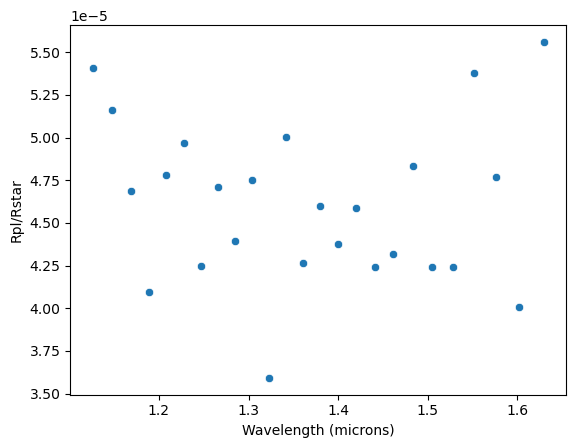

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

data = all_spectra[0].out_data

print(data)

fig, ax = plt.subplots()
# ["Wavelength (microns)", "Delta Wavelength (microns)", "(Rp/Rs)^2", "(Rp/Rs)^2 +/-uncertainty"]
sns.scatterplot(data=data,
                x="Wavelength (microns)",
                y="Rpl/Rstar")
plt.show()